<a href="https://colab.research.google.com/github/FranGhelfi/DH_DS_Pr-ctico_1_Grupo_8/blob/main/DS_TP1_MRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importamos librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import folium

Code to read csv file into Colaboratory:

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1WnQOD6bK1MWk7GwrP7hiRfhgJ3YYXakM'
fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('properati.csv')  
data_original = pd.read_csv('properati.csv')
# Dataset is now stored in a Pandas Dataframe

# Exploración de datos

---
Nuestro DataFrame es data_original, con el .csv en bruto



Para ver el tamaño en filas y columnas de nuestra base de datos en bruto

In [ ]:
data_original.shape

(121220, 26)

Analizamos las diferentes columnas en una tabla, incluyendo tipos, cantidad de nulos, porcentaje de nulos y cantida de value_counts

In [ ]:
tabla_inicial = data_original.dtypes
tabla_inicial = pd.concat([tabla_inicial, (data_original.isna().sum() / data_original.shape[0])], axis=1, sort=False)
tabla_inicial = tabla_inicial.rename(columns={0: 'Type', 1: 'Null %'})
tabla_inicial = pd.concat([tabla_inicial, data_original.isna().sum()], axis=1, sort=False)
tabla_inicial = tabla_inicial.rename(columns={0: 'Null count'})
for x in tabla_inicial.index:
  tabla_inicial.loc[tabla_inicial.index.str.contains(x), 'Value counts'] = data_original[x].value_counts().count().astype(int)

stat_describe = data_original.describe().transpose()
for x in stat_describe.columns:
  stat_describe[x] = stat_describe[x].apply(lambda x: '%.0f' % x)

tabla_inicial = pd.concat([tabla_inicial, stat_describe], axis=1, sort=False)

tabla_inicial.sort_values('std')

,Type,Null %,Null count,Value counts,count,mean,std,min,25%,50%,75%,max
floor,float64,0.934837,113321,182.0,7899,17,120,1,1,3,6,3150
expenses,float64,0.882346,106958,982.0,14262,5009,120440,1,1000,2000,4000,10001500
surface_total_in_m2,float64,0.324435,39328,1687.0,81892,234,1782,0,50,84,200,200000
lat,float64,0.425260,51550,46495.0,69670,-35,2,-55,-35,-35,-34,5
lon,float64,0.425260,51550,46522.0,69670,-59,2,-76,-59,-58,-58,-54
rooms,float64,0.609058,73830,31.0,47390,3,2,1,2,3,4,32
price,float64,0.168372,20410,9746.0,100810,468526,2260101,0,110000,185000,420000,650000000
price_usd_per_m2,float64,0.433947,52603,25567.0,68617,2160,2759,1,1218,1800,2486,206333
price_per_m2,float64,0.276869,33562,25185.0,87658,6912,28379,2,1550,2213,3356,4000000
Unnamed: 0,int64,0.000000,0,121220.0,121220,60610,34993,0,30305,60610,90914,121219


Vemos una generalidad de los datos con los primeros 5 registros

In [ ]:
data_original.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,1676227.5,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,64000.0,USD,1129248.0,64000.0,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


Podemos hacer lo mismo, pero tomar 5 filas al azar

In [ ]:
data_original.sample(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
99346,99346,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,NaN,NaN,NaN,1400000.0,ARS,1385395.67,78517.14,53.0,47.0,1481.455472,29787.234043,NaN,NaN,NaN,http://www.properati.com.ar/1bmjf_venta_depart...,Sergio Villella Inmobiliaria presenta departam...,Paraguay 2200 - Venta departamento un dormitorio,https://thumbs4.properati.com/3/6A0msOOojIR_4f...
118215,118215,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,53.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1cei2_venta_depart...,Una esquina soñada frente a Plaza Guadalupe.Un...,Departamento - Palermo,https://thumbs4.properati.com/5/AaYDgZFWQaxBJT...
79906,79906,sell,apartment,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Argentina,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,3457000.0,ARS,3459058.30,196041.73,120.0,87.0,1633.681083,39735.632184,NaN,NaN,NaN,http://www.properati.com.ar/1aw5u_venta_depart...,"Es un proyecto único por su ubicación, calidad...",Departamento en Los Castaños,https://thumbs4.properati.com/6/0TyxKPMlbTnYlc...
14224,14224,sell,house,Punilla,|Argentina|Córdoba|Punilla|,Argentina,Córdoba,3839996.0,"-31.0946959,-64.4897194",-31.094696,-64.489719,100000.0,USD,1764450.00,100000.00,300.0,100.0,333.333333,1000.000000,NaN,NaN,NaN,http://www.properati.com.ar/16rl3_venta_casa_p...,CODIGO: ubicado en: SAN LUIS 111 - Publicado...,VENDO PROPIEDAD VILLA CARLOS PAZ,https://thumbs4.properati.com/4/jjfKuCXsF8yEAM...
117817,117817,sell,house,Lanús,|Argentina|Bs.As. G.B.A. Zona Sur|Lanús|Lanús|,Argentina,Bs.As. G.B.A. Zona Sur,NaN,NaN,NaN,NaN,80000.0,USD,1411560.00,80000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/1ce03_venta_casa_l...,"Casa en lote de 8,66x35 aprox. Ingreso a Livin...",Casa - Lanús Este,https://thumbs4.properati.com/2/SjtQ68FkLY0m5B...


# Primeras observaciones

Sabemos que la columna "operation" no tiene NaN, con (value_count) la cantidad de valores que hay.\
Si son todas ventas su tamaño debe ser igual al DataSet

---



In [ ]:
data_original["operation"].value_counts() == data_original.shape[0]

sell    True
Name: operation, dtype: bool

Vimos que la columna "Unnamed: 0" no tiene NaN, es lo mismo que el índice?

In [ ]:
# Contamos la cantidad de verdaderos que devuelve la siguente igualdad:
var_1 = (data_original["Unnamed: 0"] == data_original.index).value_counts()
# redundante, pero comparamos el conteo anterior, con el tamaño del data set.
var_1 == data_original.shape[0]

True    True
dtype: bool

la columna "country_name" no tiene NaN. Son todas propiedades de ARG?

In [ ]:
var_country = data_original["country_name"].value_counts()
# redundantem pero al conteo anterior, lo comparamos con el tamaño del data set.
var_country.sum() == data_original.shape[0]

True

Los campos a los que por ahora no le encontramos utilidad son: operaciones / Unnamed: 0 / country_name / imágenes / floor / expenses \
Antes de limpiarlos, hacemos una copia de la data y descartamos las columnas seleccionadas.

In [ ]:
data_edit = data_original.copy()

data_edit.drop(["operation", "Unnamed: 0", "country_name", "image_thumbnail", "floor", "expenses"], axis = 1, inplace=True)
# Mostramos los primero 5 registros
data_edit.head(5)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,properati_url,description,title
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,PH,Liniers,|Argentina|Capital Federal|Liniers|,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,95000.0,USD,1676227.5,95000.0,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado
4,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,64000.0,USD,1129248.0,64000.0,35.0,35.0,1828.571429,1828.571429,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...


Con las URL podemos hacer una suerte de doble chequeo, ya que sospechamos que ellas se conforman con las columnas del DataSet.\
Por ahora dejamos las URL

# Tipos de propiedades

Ya vimos que en la columna "propery_type" no hay NaNs.\
Cuántos tipos de propiedades hay?

In [ ]:
data_property_type = data_edit["property_type"]
data_property_type.unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

De estas 4 coategorías, todas tienen mas de 1 entrada? Explicando que son una variable importante.

In [ ]:
total = data_edit["property_type"].value_counts() > 1
total.sum()
# Si, todas tienen más de una propiedad asociada, por lo que esperamos que haya información útil

4

Qué cantidad de porpiedades por tipo hay?\
Esto es como hacer los dos pasos anteriores, en uno!!

In [ ]:
data_property_type.value_counts()

apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64

Proporción de tipos de propiedades

Proporcion de PH: 0.05 %
Proporcion de Dptos: 0.59 %
Proporcion de Casas: 0.33 %
Proporcion de Locales: 0.03 %
1.0
                        En un gráfico


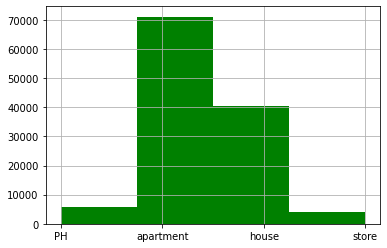

In [ ]:
cant_PH = (data_property_type == "PH").sum()
prop_PH = cant_PH / data_property_type.shape[0]

cant_apartment = (data_property_type == "apartment").sum()
prop_apartment = cant_apartment / data_property_type.shape[0]

cant_house = (data_property_type == "house").sum()
prop_house = cant_house / data_property_type.shape[0]

cant_store = (data_property_type == "store").sum()
prop_store = cant_store / data_property_type.shape[0]

print("Proporcion de PH:", round(prop_PH, 2),"%")
print("Proporcion de Dptos:", round(prop_apartment,2),"%")
print("Proporcion de Casas:", round(prop_house,2),"%")
print("Proporcion de Locales:", round(prop_store,2),"%")
print(prop_PH+prop_apartment+prop_house+prop_store)
print("              \
          En un gráfico")
data_property_type.hist(bins=4, color="green")

# Provincias y localidades

Qué y cuántos datos tenemos en la columna "place_name"?

In [ ]:
data_edit["place_name"].value_counts()

Córdoba           9254
Rosario           8504
Mar del Plata     6534
Tigre             3324
Nordelta          3315
                  ... 
Alejandro Roca       1
Trenel               1
Fighiera             1
Dina Huapi           1
William Morris       1
Name: place_name, Length: 1060, dtype: int64

Qué y cuántos datos tenemos en "place_with_parents_name"?

In [ ]:
data_edit["place_with_parent_names"].value_counts()

|Argentina|Santa Fe|Rosario|                                                    8504
|Argentina|Córdoba|Córdoba|                                                     6606
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|                          6534
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|                             3315
|Argentina|Capital Federal|Belgrano|                                            2992
                                                                                ... 
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|Gral San Martin|             1
|Argentina|Chubut|Playa Unión|                                                     1
|Argentina|Chubut|Corcovado|                                                       1
|Argentina|Buenos Aires Interior|Nueve de Julio|                                   1
|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|Barrio Cerrado "La Chacra"|       1
Name: place_with_parent_names, Length: 1164, dtype: int64

Vemos que se repite mucho Argentina.\
En todas las entradas está "Argentina"?

In [ ]:
test_1 = data_edit["place_with_parent_names"].str.contains('Argentina').sum() / data_edit.shape[0]
test_1
# Si!

1.0

Generamos una nueva columna, donde quitamos "Argentina" y eliminamos el "|" generando listas para cada fila

In [ ]:
data_edit["fran_place_levels"] = data_edit["place_with_parent_names"].apply(lambda x: [z.strip() for z in x.split('|') if z != '' and 'Argentina' not in z])
data_edit["fran_place_levels"]

0                              [Capital Federal, Mataderos]
1                        [Bs.As. G.B.A. Zona Sur, La Plata]
2                              [Capital Federal, Mataderos]
3                                [Capital Federal, Liniers]
4         [Buenos Aires Costa Atlántica, Mar del Plata, ...
                                ...                        
121215                          [Capital Federal, Belgrano]
121216       [Bs.As. G.B.A. Zona Norte, San Isidro, Beccar]
121217                     [Capital Federal, Villa Urquiza]
121218    [Buenos Aires Costa Atlántica, Mar del Plata, ...
121219                                    [Capital Federal]
Name: fran_place_levels, Length: 121220, dtype: object

Para quedarnos con un recuento de datos por provincias, generamos una nueva columna y sobre la anterior pedimos una separación por el primer índice de cada lista

In [ ]:
data_edit["fran_provincia"] = data_edit["fran_place_levels"].apply(lambda x: x[0])
data_edit["fran_provincia"].value_counts()

Capital Federal                 32316
Bs.As. G.B.A. Zona Norte        25560
Bs.As. G.B.A. Zona Sur          13952
Córdoba                         12069
Santa Fe                        10172
Buenos Aires Costa Atlántica    10006
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Interior            2291
Río Negro                         808
Neuquén                           733
Mendoza                           681
Tucumán                           674
Corrientes                        583
Misiones                          464
Entre Ríos                        369
Salta                             278
Chubut                            259
San Luis                          252
La Pampa                          157
Formosa                            65
Chaco                              57
San Juan                           40
Tierra Del Fuego                   31
Catamarca                          27
Jujuy                              26
Santa Cruz                         20
Santiago Del

Para validar la separación anterior con la base original:

In [ ]:
data_edit["fran_provincia"].value_counts().sum() == data_edit.shape[0]

True

Hacemos una visualización general.

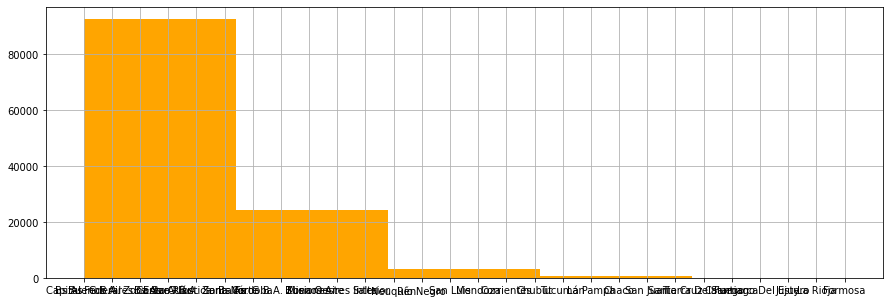

In [ ]:
data_edit["fran_provincia"].hist(bins=5, figsize= [15,5], color="orange")

A partir de la columna "fran_place_levels" (listas de ubicaciones sin ARG) tomamos con x[1:] la localidad y vemos cuántas hay de cada una

In [ ]:
data_edit["fran_localidad"] = data_edit["fran_place_levels"].apply(lambda x: ', '.join(x[1:]))
data_edit["fran_localidad"].value_counts()
#data_edit["fran_localidad"].value_counts().sum()

Rosario            8504
Córdoba            6606
Mar del Plata      6534
                   4900
Tigre, Nordelta    3315
                   ... 
Quemú Quemú           1
Calmayo               1
Chajarí               1
Las Talitas           1
Venado Tuerto         1
Name: fran_localidad, Length: 1117, dtype: int64

# Rooms
La columna 'rooms' es de tipo 'float' pero es más lógico tenerla como 'int'.

Primero reemplazamos los valores null por 9999 para poder convertir toda la columna




In [ ]:
mask = data_edit['rooms'].isnull()
data_edit.loc[mask, 'rooms'] = 9999
data_edit['rooms'] = data_edit['rooms'].astype(int)

Primero chequeamos los números escritos en forma de texto

In [ ]:
data_edit["rooms"].value_counts()

9999    73830
3       12567
2       12433
4        7937
1        7377
5        3782
6        1403
7         770
8         409
10        226
9         184
11         72
12         65
13         33
14         27
15         26
17         16
16         11
20         11
22          8
18          6
21          5
19          4
25          4
30          4
32          3
23          2
31          1
24          1
27          1
28          1
29          1
Name: rooms, dtype: int64

Luego reemplazamos los textos por números.

In [ ]:
numeros_texto = {'uno': '1', 'dos': '2', 'tres': '3', 'cuatro': '4', 'cinco': '5', 'seis': '6', 'siete':'7', 'ocho': '8', 'nueve': '9'}
for x in list(numeros_texto.keys()):
  print(data_edit['title'].str.contains(x).sum())
print("-------")
print(data_edit["title"])

24
1268
398
79
19
6
4
0
0
-------
0                        2 AMB TIPO CASA SIN EXPENSAS EN PB
1         VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37   ...
2                  2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3                              PH 3 amb. cfte. reciclado   
4         DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...
                                ...                        
121215           Torre Forum Alcorta- Impecable 3 ambientes
121216    Ruca Inmuebles | Venta | Lomas de San Isidro |...
121217    VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...
121218    2 amb. C/ dep. de servicio al contrafrente| Re...
121219           Departamento apto profesional en el Centro
Name: title, Length: 121220, dtype: object


In [ ]:
# El primer print indica la cant de True para "uno"
# El segundo print indica la cant de True de valores no convertidos
for key, value in numeros_texto.items():
  mask = data_edit['title'].str.contains(key)
  print(mask.sum())
  data_edit.loc[mask, 'title'] = data_edit.loc[mask]['title'].apply(lambda x: str(x).replace(key, value))
  print(data_edit['title'].str.contains(key).sum())

24
0
1268
0
398
0
79
0
19
0
6
0
4
0
0
0
0
0


Pasamos los 0 a NaN

In [ ]:
mask_nulos_m2 = data_edit["surface_covered_in_m2"] == 0
data_edit.loc[mask_nulos_m2, "surface_covered_in_m2"] = np.nan
# Pedimos la cantidad de NaN de m2 y que muetre la columna "romms".
# Esto quiere decir que no hay valore de "rooms" con valores NaN en m2 
data_edit[mask_nulos_m2]['rooms'].value_counts().sort_index()

9999    2
Name: rooms, dtype: int64

Establecemos el patrón regex para detectar ambientes. Capturamos cualquier número seguido de un espacio y el string 'amb'.

In [ ]:
patron = '(\d)+\samb'
regex = re.compile(patron, flags = re.IGNORECASE)

Primero vemos cuantas filas tienen 'amb' en 'title' y null en 'rooms'

In [ ]:
resultado_title_rooms = data_edit['title'].str.contains(regex) & (data_edit['rooms'] == 9999)
resultado_title_rooms.sum()
# Esto es que hay 8820 registros donde hay "x amb" con rooms "9999" = NaN, para la columna Title

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


8820

Luego vemos cuantas filas tienen 'amb' en 'description' y null en 'rooms'

In [ ]:
resultado_description_rooms = data_edit['description'].str.contains(regex) & (data_edit['rooms'] == 9999)
resultado_description_rooms.sum()
# Esto es que hay 18902 registros donde hay "x amb" con rooms "9999" = NaN, para la columna Description

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


18902

Tenemos más coincidencias desde el campo 'description' así que comenzamos por aqui y extraemos el valor númerico

In [ ]:
# search(x)[1] es "(\d+)"
data_edit.loc[resultado_description_rooms, 'rooms'] = data_edit.loc[resultado_description_rooms, 'description'].apply(lambda x: float(regex.search(x)[1]))
data_edit[resultado_description_rooms]['rooms'].value_counts().sort_index()

0.0      25
1.0    1062
2.0    6331
3.0    6250
4.0    3678
5.0    1080
6.0     324
7.0     122
8.0      16
9.0      14
Name: rooms, dtype: int64

In [ ]:
# estos son los regitros que nos hacer ruido con el regex... ¿que facciamo?
larala = data_edit[resultado_description_rooms]['rooms'] == 0.0
print(data_edit[resultado_description_rooms]["description"][larala])

11334     CODIGO: 2461-1A790 ubicado en: Piedras al 1000...
17721     CODIGO: 2461-1A761 ubicado en: Hipolito Yrigoy...
17723     CODIGO: 2461-1A830 ubicado en: Av Cordoba al 6...
17724     CODIGO: 2461- 1A782 ubicado en: Av Independenc...
17725     CODIGO: 2461-1A723 ubicado en: Combate de los ...
19849     CODIGO: 2461-1A843 ubicado en: Av. San Juan al...
23884     CODIGO: 1259-Dr J Valentin Gomez 3500 ubicado ...
24730     Apto profesional. Casa para uso comercial de 1...
31827     Venta de chalet 10 ambientes en Bella Vista.La...
32106     EXQUISITA CASA EN LA MEJOR ZONA DE BELGRANO RO...
42609     CODIGO: 2461-1A464 ubicado en: Defensa -  Publ...
42611     CODIGO: 2461-1A852 ubicado en: Tinogasta al 58...
51221     CODIGO: 2461-1A854 ubicado en: Irigoyen al 220...
59858     CODIGO: 2461-1A857 ubicado en: Independencia a...
63465     CODIGO: 2461-1A858 ubicado en: Venezuela al 40...
73628     OPRTUNIDAD PARA MULTIPLE DESARROLLOEN PLENO CE...
73641     OPRTUNIDAD PARA MULTIPLE DESAR

Comprobamos la reducción de nulls en 'rooms', data_original vs data_edit

In [ ]:
print("Nulls que había = ", data_original['rooms'].isnull().sum())
print("Nulls que hay =", (data_edit['rooms'] == 9999).sum())

Nulls que había =  73830
Nulls que hay = 54928


Extraemos ahora desde 'title'

In [ ]:
resultado_title_rooms = data_edit['title'].str.contains(regex) & (data_edit['rooms'] == 9999)
resultado_title_rooms.sum()
# Esto es que hay 2839 registros con "title" "x amb" y rooms "9999"

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


2839

In [ ]:
data_edit.loc[resultado_title_rooms, 'rooms'] = data_edit.loc[resultado_title_rooms, 'title'].apply(lambda x: float(regex.search(x)[1]))
data_edit[resultado_title_rooms]['rooms'].value_counts().sort_index()

0.0      3
1.0    144
2.0    750
3.0    886
4.0    660
5.0    260
6.0     87
7.0     31
8.0     16
9.0      2
Name: rooms, dtype: int64

Vemos cuántos null hemos quitado, data_original VS data_edit

In [ ]:
print(data_original['rooms'].isnull().sum())
print((data_edit['rooms'] == 9999).sum())

73830
52089


Revisamos el resultado

In [ ]:
data_edit['rooms'].value_counts().sort_index()
# Hay que ver con los valores > a 10 de rooms...

0.0          28
1.0        8583
2.0       19514
3.0       19703
4.0       12275
5.0        5122
6.0        1814
7.0         923
8.0         441
9.0         200
10.0        226
11.0         72
12.0         65
13.0         33
14.0         27
15.0         26
16.0         11
17.0         16
18.0          6
19.0          4
20.0         11
21.0          5
22.0          8
23.0          2
24.0          1
25.0          4
27.0          1
28.0          1
29.0          1
30.0          4
31.0          1
32.0          3
9999.0    52089
Name: rooms, dtype: int64

Acomodamos rooms para los 'monoambientes'

In [ ]:
# resultado_description_rooms = data_edit['description'].str.contains(regex) & data_edit['rooms'].isnull()
# Pasamos a min+uscula la descripción:
data_edit['description'] = data_edit['description'].apply(lambda x: str(x).lower())

mask_monoambiente = data_edit['description'].str.contains('monoambiente') & (data_edit['rooms'] == 9999)
mask_monoambiente.sum()
# Esto son 3676 registros con valor nulo en rooms (9999) y que se describen como monoambientes

3676

In [ ]:
# cantidad de monoambientes con "x rooms"
data_edit[data_edit['description'].str.contains('monoambiente')]['rooms'].value_counts()

9999.0    3676
1.0       2641
2.0        679
3.0        224
4.0         68
5.0         26
6.0         12
8.0         10
10.0         5
7.0          2
25.0         1
Name: rooms, dtype: int64

In [ ]:
data_edit[data_edit['description'].str.contains('monoambiente')]['rooms'].sum()

36761638.0

In [ ]:
# A todo lo que dice "monoambiente" en room, asignamos 1 room
data_edit.loc[data_edit['description'].str.contains('monoambiente'), 'rooms'] = 1
# Lo mostramos:
data_edit[data_edit['description'].str.contains('monoambiente')]['rooms'].value_counts()

1.0    7344
Name: rooms, dtype: int64

Pudimos reducir la cantida de nulls en rooms en la siguiente relación

In [ ]:
print("Null en data_original =", (data_original['rooms'].isnull()).sum())
print("% Null en data_original =", round((data_original['rooms'].isnull()).sum() / data_edit.shape[0]*100,2),"%")
print("Null en data_edit =", (data_edit['rooms'] == 9999).sum())
print("Pudimos reducir la cantidada de Nulls a = ", round((data_edit['rooms'] == 9999).sum() / data_edit.shape[0]*100,2),"%")

Null en data_original = 73830
% Null en data_original = 60.91 %
Null en data_edit = 48413
Pudimos reducir la cantidada de Nulls a =  39.94 %


Pasamos los registros "9999" a Null postas!

In [ ]:
data_edit.loc[data_edit['rooms'] == 9999, 'rooms'] = np.nan
data_edit['rooms'].isnull().sum()

48413

# Superficie

Sabemos qué la cantidad de valores faltantes son:\
 surface_covered_in_m2 =  0.164222\
 surface_total_in_m2   =  0.324435

> m2 totales
 



Listamos los datos de superficies m2 totales

In [ ]:
data_edit["surface_total_in_m2"].value_counts().sort_index()

0.0         383
10.0         21
11.0          8
12.0         12
13.0          6
           ... 
100350.0      1
107000.0      4
110000.0      3
154438.0      1
200000.0      2
Name: surface_total_in_m2, Length: 1687, dtype: int64

Algunos estadísticos descriptivos iniciales sobre m2 totales:

In [ ]:
print("Cant Nulos:", data_edit["surface_total_in_m2"].isna().sum())
print("Media de m2:", data_edit['surface_total_in_m2'].mean())
print("m2 más fr:", data_edit['surface_total_in_m2'].mode())
print("mediana m2:", data_edit['surface_total_in_m2'].median())
print("max m2:", data_edit['surface_total_in_m2'].max())
print("min m2:", data_edit['surface_total_in_m2'].min())

Cant Nulos: 39328
Media de m2: 233.79532799296635
m2 más fr: 0    50.0
dtype: float64
mediana m2: 84.0
max m2: 200000.0
min m2: 0.0


Vemos que hay superfiecies totales de 0 m2. Cuántas hay?

In [ ]:
sup_1 = (data_edit['surface_total_in_m2']==0).sum()
sup_1

383

Nulls?

In [ ]:
sup_2 = data_edit['surface_total_in_m2'].isna().sum()
sup_2

39328

Separamos los m2 en cuartiles

In [ ]:
cuartiles_m2_T = data_edit['surface_total_in_m2'].quantile([0.25,0.5,0.75])
cuartiles_m2_T

0.25     50.0
0.50     84.0
0.75    200.0
Name: surface_total_in_m2, dtype: float64

> m2 cuviertos\


Vemos si hay difeencias entre los DF (editado vs original)

In [ ]:
Test_1=data_original["surface_covered_in_m2"]==data_edit["surface_covered_in_m2"]
Test_1.value_counts()

True     101311
False     19909
Name: surface_covered_in_m2, dtype: int64

Veamos cuántas propiedades no tienen valores para superficie cuvierta.

In [ ]:
data_edit["surface_covered_in_m2"].isna().sum()

19909

In [ ]:
# Esto es solo para mostrar que usar isna() o isnull(), en este caso es lo mismo.
data_edit["surface_covered_in_m2"].isnull().sum()

19909

Algunos estadísticos iniciales descriptivos sobre m2 cueviertos

In [ ]:
print("Cant Nulos inicial:", data_original["surface_covered_in_m2"].isna().sum())
print("Media de m2 inicial:", data_original['surface_covered_in_m2'].mean())
print("m2 más fr inicial:", data_original['surface_covered_in_m2'].mode())
print("mediana m2: inicial", data_original['surface_covered_in_m2'].median())
print("m2_0 inicial:", (data_original['surface_covered_in_m2']== 0).sum()) 

Cant Nulos inicial: 19907
Media de m2 inicial: 133.05018112186985
m2 más fr inicial: 0    40.0
dtype: float64
mediana m2: inicial 75.0
m2_0 inicial: 2


Sumando todas las categorías, tenemos el tamaño del DF

In [ ]:
sup_2 = data_edit["surface_covered_in_m2"] == 0
print("m2_cuv_0:", sup_2.sum())
sup_3 = data_edit["surface_covered_in_m2"].notnull()
print("m2_cuv_>_0:", sup_3.sum())
sup_4 = data_edit["surface_covered_in_m2"].isnull()
print("sup_null:", sup_4.sum())
test_2 = (sup_2 + sup_3 + sup_4).sum() == data_edit.shape[0]
print(test_2)

m2_cuv_0: 0
m2_cuv_>_0: 101311
sup_null: 19909
True


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


Separamos en cuartiles los m2 cubiertos




In [ ]:
cuartiles_m2_cuv = data_edit['surface_covered_in_m2'].quantile([0.25,0.5,0.75])
cuartiles_m2_cuv

0.25     45.0
0.50     75.0
0.75    150.0
Name: surface_covered_in_m2, dtype: float64

Evaluamos si los m2 cuviertos son mayores que los totales en el mimsmo registro

In [ ]:
test_3 = (data_edit["surface_covered_in_m2"] > data_edit["surface_total_in_m2"]).value_counts()
test_3

False    120114
True       1106
dtype: int64

Grafico de cuartiles de sup total

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


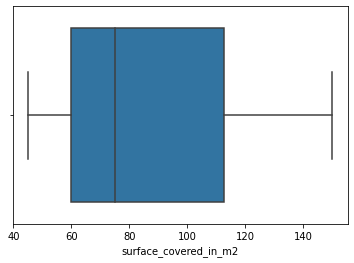

In [ ]:
data_box = data_edit["surface_total_in_m2"]
sns.boxplot(cuartiles_m2_cuv, data=data_edit)

Contamos la cantidad de propiedades con valores nulos en sup total o cubierta

In [ ]:
print("Sup_tot o Sup_cuv Null:", (data_edit['surface_covered_in_m2'].isna() | data_edit['surface_total_in_m2'].isna()).sum())
print("Sup_cuv_null:", data_edit['surface_covered_in_m2'].isna().sum())
print("Sup_tot_null:", data_edit['surface_total_in_m2'].isna().sum())
print("Sup_tot y Sup_cuv Null:", (data_edit['surface_covered_in_m2'].isna() & data_edit['surface_total_in_m2'].isna()).sum())

Sup_tot o Sup_cuv Null: 46868
Sup_cuv_null: 19909
Sup_tot_null: 39328
Sup_tot y Sup_cuv Null: 12369


Vamos a estimar los m2 cubiertos a partir de la cantidad de rooms. Primero buscamos un valor medio de m2 cubiertos por room

In [ ]:
tabla_m2 = data_edit.pivot_table(index='property_type', aggfunc={'rooms':'mean', 'price_aprox_usd':'mean', 'surface_total_in_m2':'mean' })
tabla_m2['m2_room'] = tabla_m2['surface_total_in_m2'] / tabla_m2['rooms']
tabla_m2

,price_aprox_usd,rooms,surface_total_in_m2,m2_room
property_type,,,,
PH,147689.419611,3.178985,122.297417,38.470588
apartment,187406.880406,2.419855,96.605873,39.922173
house,329696.776384,4.292335,507.438686,118.219741
store,440257.062940,2.504110,494.512403,197.480336


In [ ]:
for x in data_edit['property_type'].unique():
  this_mask = data_edit['property_type'].str.contains(x) & data_edit["surface_covered_in_m2"].isnull() & data_edit["rooms"].notnull()
  print(this_mask.sum())
  multiplicador = tabla_m2.loc[tabla_m2.index.str.contains(x)]['m2_room']
  print(multiplicador[0])
  data_edit.loc[this_mask, 'surface_covered_in_m2'] = data_edit[this_mask]["rooms"] * tabla_m2.loc[tabla_m2.index.str.contains(x)]['m2_room'][0]

574
38.470588157506825
5985
39.922172792198864
2852
118.21974094742617
88
197.48033591578448


Al final logramos reducir los null completamente



In [ ]:
print(data_original["surface_covered_in_m2"].isnull().sum())
print(data_edit["surface_covered_in_m2"].isnull().sum())

19907
10410


Ya con la columna "surface_covered_in_m2" completa, volvemos a estimar los null de "rooms"

In [ ]:
for x in data_edit['property_type'].unique():
  this_mask = data_edit['property_type'].str.contains(x) & data_edit["surface_covered_in_m2"].notnull() & data_edit["rooms"].isnull()
  print(this_mask.sum())
  multiplicador = tabla_m2.loc[tabla_m2.index.str.contains(x)]['m2_room'][0]
  print(multiplicador)
  data_edit.loc[this_mask, 'rooms'] = data_edit[this_mask]["surface_covered_in_m2"] / tabla_m2.loc[tabla_m2.index.str.contains(x)]['m2_room'][0]

995
38.470588157506825
15484
39.922172792198864
18646
118.21974094742617
2878
197.48033591578448


Comparación de valoes originales y transformados:

In [ ]:
print((data_original["rooms"].isnull()).sum())
print((data_edit["rooms"].isnull()).sum())

print((data_original["surface_covered_in_m2"].isnull()).sum())
print((data_edit["surface_covered_in_m2"].isnull()).sum())

73830
10410
19907
10410


Vemos como variaron los estadísticos

In [ ]:
print("Media Sup Cuv Original =", round(data_original['surface_covered_in_m2'].mean(),2))
print("Media Sup Cuv Edit =",round(data_edit['surface_covered_in_m2'].mean(),2))

Media Sup Cuv Original = 133.05
Media Sup Cuv Edit = 141.5


In [ ]:
print("Media rooms Original =",round(data_original['rooms'].mean(),2))
print("Media rooms Edit =",round(data_edit['rooms'].mean(),2))

Media rooms Original = 3.08
Media rooms Edit = 2.63


Creamos una columna para almacenar los valores de m2 por room medios según el tipo de propiedad

In [ ]:
for x in data_edit['property_type'].unique():
  this_mask = data_edit['property_type'].str.contains(x)
  data_edit.loc[this_mask, 'fran_m2_room_xtipo'] = tabla_m2.loc[tabla_m2.index.str.contains(x)]['m2_room'][0]
data_edit['fran_m2_room_xtipo'].value_counts()

39.922173     71065
118.219741    40268
38.470588      5751
197.480336     4136
Name: fran_m2_room_xtipo, dtype: int64

Creamos una columna para almacenar los m2_room de cada propiedad



In [ ]:
for x in data_edit['property_type'].unique():
  this_mask = data_edit['property_type'].str.contains(x) & data_edit["surface_covered_in_m2"].notnull() & data_edit["rooms"].notnull()
  data_edit.loc[this_mask, 'fran_m2_room'] = data_edit["surface_covered_in_m2"] / data_edit["rooms"]
data_edit['fran_m2_room'].value_counts()

39.922173     20366
118.219741    16148
118.219741     3000
197.480336     2929
20.000000      2526
              ...  
59.857143         1
35.285714         1
27.625000         1
266.666667        1
56.222222         1
Name: fran_m2_room, Length: 1752, dtype: int64

In [ ]:
data_edit['surface_total_in_m2'] / data_edit['fran_m2_room_xtipo']

0         1.429664
1              NaN
2         1.377681
3              NaN
4         0.876706
            ...   
121215    2.830507
121216    3.045177
121217    1.152242
121218    1.202339
121219    1.928753
Length: 121220, dtype: float64

Si m2 cuviertos son mayores que los m2 totales, hay error

In [ ]:
superficie = data_edit['surface_covered_in_m2'] > data_edit['surface_total_in_m2']
superficie.sum()
#vemos que hay 3898 registros con este error

3898

Ploteamos lo que tenemos:

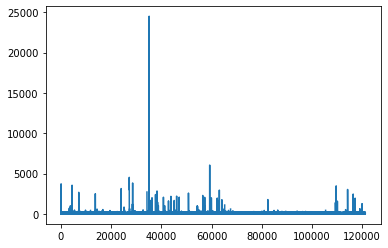

In [ ]:
data_edit['fran_m2_room'].plot()

Descripción de la columna 'fran_m2_room'

In [ ]:
data_edit[data_edit['fran_m2_room'].notnull()]['fran_m2_room'].describe()

count    1.108020e+05
mean              inf
std               NaN
min      1.428571e-01
25%      2.533333e+01
50%      3.992217e+01
75%      6.666667e+01
max               inf
Name: fran_m2_room, dtype: float64

Descripción de la columna "fran_m2_room" para cuando los m2 son menores a 118

In [ ]:
mask = data_edit['fran_m2_room'] < 118
data_edit[mask]['fran_m2_room'].describe()

count    85660.000000
mean        33.490579
std         13.896766
min          0.142857
25%         23.333333
50%         33.333333
75%         39.922173
max        117.800000
Name: fran_m2_room, dtype: float64

Tabla de m2 por localidad y tipo de propiedades.

In [ ]:
tabla_m2_room = data_edit[mask].pivot_table('surface_covered_in_m2', 'fran_provincia', columns='property_type')
# tabla_m2_room.reindex(tabla_m2_room['property_type'].sort_values(by='apartment', ascending=False).index)
tabla_m2_room

property_type,PH,apartment,house,store
fran_provincia,,,,
Bs.As. G.B.A. Zona Norte,86.452947,71.725799,188.749618,131.176471
Bs.As. G.B.A. Zona Oeste,83.906295,56.174654,154.915631,142.733333
Bs.As. G.B.A. Zona Sur,89.156153,68.128778,152.406136,151.900000
Buenos Aires Costa Atlántica,85.694223,68.861131,185.486561,205.750000
Buenos Aires Interior,84.410397,71.972415,161.888288,287.000000
Capital Federal,92.496568,77.486729,186.027613,92.388235
Catamarca,NaN,311.818182,170.333333,NaN
Chaco,NaN,87.454601,156.250000,NaN
Chubut,78.400000,85.755139,134.388889,84.000000


Vemos cómo nos quedan las columnas del DS_edit hasta ahora

In [ ]:
data_edit.columns

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'geonames_id', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'rooms',
       'properati_url', 'description', 'title', 'fran_place_levels',
       'fran_provincia', 'fran_localidad', 'fran_m2_room_xtipo',
       'fran_m2_room'],
      dtype='object')

# Precios y monedas

Algunos estadisticos de los precios

In [ ]:
tabla_monedas = data_edit.pivot_table(index='currency', aggfunc={'price':'mean', 'price_aprox_usd':'mean', 'surface_total_in_m2':'mean' })
for x in tabla_monedas.columns:
  tabla_monedas[x] = tabla_monedas[x].apply(lambda x: '%.0f' % x)
tabla_monedas

,price,price_aprox_usd,surface_total_in_m2
currency,,,
ARS,1798580,101028,133
PEN,665000,204994,nan
USD,260374,260374,235
UYU,650000000,22980378,nan


In [ ]:
print("Máximo_0:", data_edit["price"].max())
print("Mínimo_0:", data_edit["price"].min())
print("Media_0:", data_edit["price"].mean())

Máximo_0: 650000000.0
Mínimo_0: 0.0
Media_0: 468525.92544390436


Pero estos son valores, no sabemos en qué moneda está. Veamos qué monedas hay y hagamos lo mismo para cada una:

In [ ]:
print("Registros por moneda")
print(data_edit["currency"].value_counts())
print(\
      )
price_USD = data_edit["currency"] == 'USD'
new_value = data_edit[price_USD]
print("Máximo USD", new_value['price'].max())
print("Mínimo USD", new_value['price'].min())
print(\
      )
price_ARS = data_edit["currency"] == 'ARS'
new_value = data_edit[price_ARS]
print("Máximo ARS", new_value['price'].max())
print("Mínimo ARS", new_value['price'].min())
print(\
      )
price_PEN = data_edit["currency"] == 'PEN'
new_value = data_edit[price_PEN]
print("PEN", new_value['price'].max())
print("   ", new_value['price'].min())
price_UYU = data_edit["currency"] == 'UYU'
new_value = data_edit[price_UYU]
print("UYU", new_value['price'].sum())

Registros por moneda
USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

Máximo USD 46545445.0
Mínimo USD 5000.0

Máximo ARS 99999999.0
Mínimo ARS 80000.0

PEN 950000.0
    380000.0
UYU 650000000.0


In [ ]:
# solo para ver algunos ejemplos
data_edit["currency"].sample(5)

4225     NaN
52937    USD
84660    USD
31519    USD
96264    ARS
Name: currency, dtype: object

Tenemos que seleccionar una de las monedas y unificar criterios.\
La cantidad de registros en USD son mas de 6 veces la cantidada de registros en $.\
Unifocamos los registros a USD

Probando ploteos:\
m2 cuviertos vs provincias

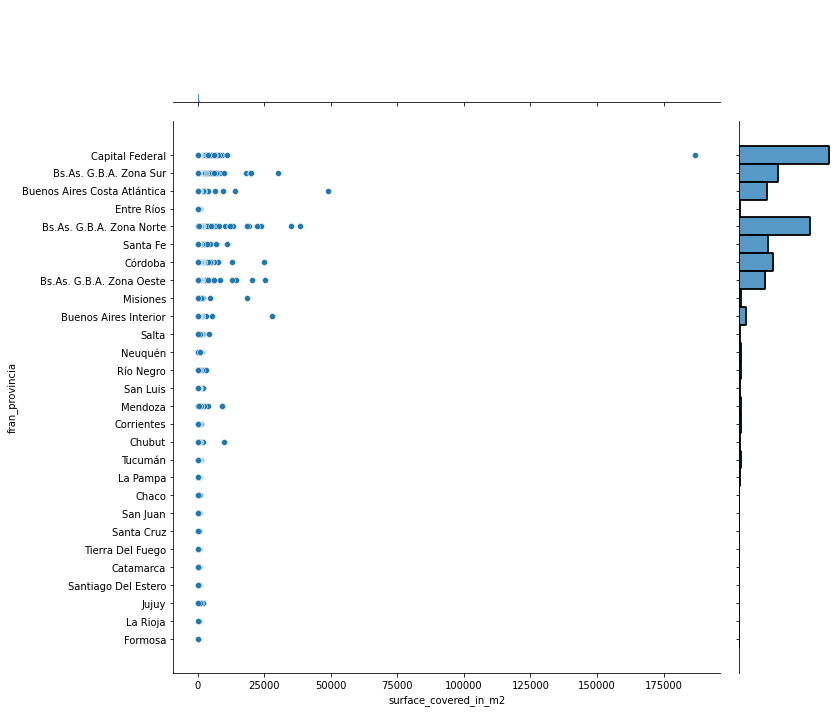

In [ ]:
import matplotlib.pyplot as plt
xd="surface_covered_in_m2"
yd=data_edit["fran_provincia"]
sns.jointplot(x=xd, y=yd, data=data_edit, height=(10))

precios vs provincias

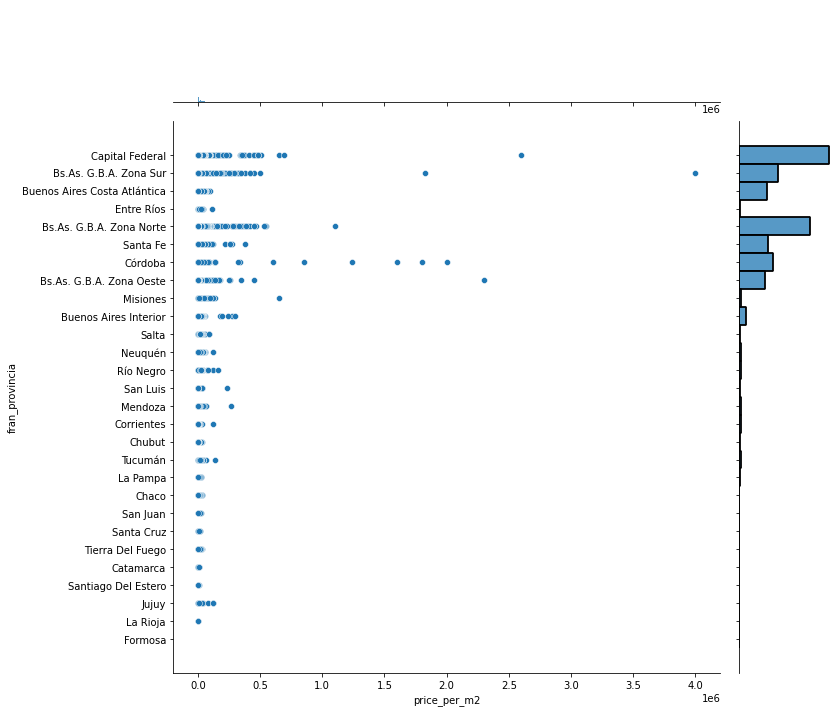

In [ ]:
xd="price_per_m2"
yd=data_edit["fran_provincia"]
sns.jointplot(x=xd, y=yd, data=data_edit, height=(10))

precios en USD vs provincias

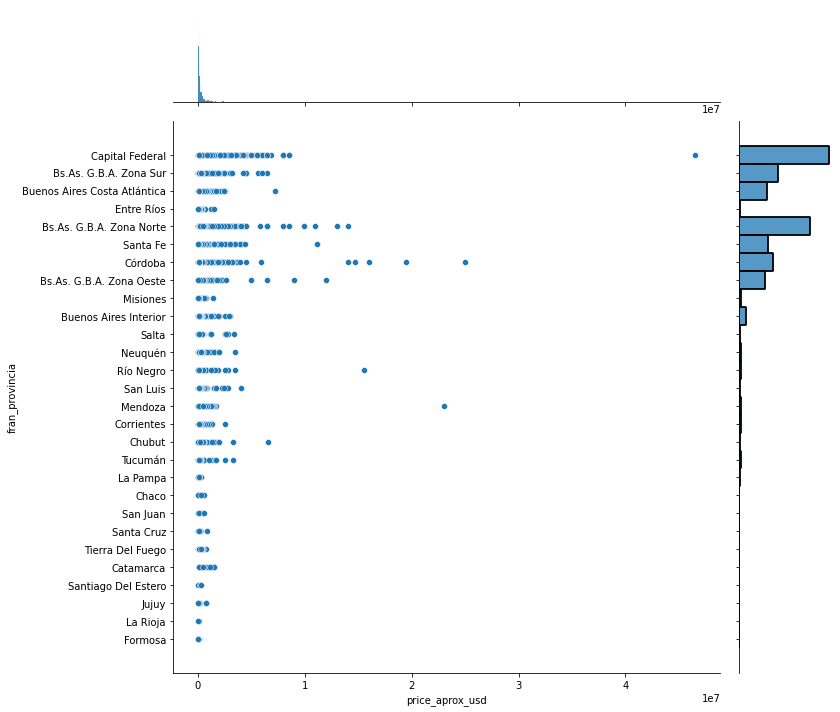

In [ ]:
xd="price_aprox_usd"
yd=data_edit["fran_provincia"]
sns.jointplot(x=xd, y=yd, data=data_edit, height=(10))

# Provincias y localidades II
Podemos aplicar RE





In [ ]:
data_place_with_parent_names = data_edit["place_with_parent_names"]
parent_names_unicos = data_place_with_parent_names.unique()
data_edit["place_with_parent_names"].value_counts().sort_values(ascending=False)
data_place_with_parent_names.value_counts().sort_values()
#pd.value_counts(parent_names_unicos)
# Vemos que Argentina se repite...

|Argentina|Bs.As. G.B.A. Zona Norte|San Fernando|Barrio Cerrado "La Chacra"|       1
|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Barrio Cerrado "El Estribo"|             1
|Argentina|Entre Ríos|Aldea Salto|                                                 1
|Argentina|Misiones|Santa Ana|                                                     1
|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|Barrio San Benito|                     1
                                                                                ... 
|Argentina|Capital Federal|Belgrano|                                            2992
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|                             3315
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|                          6534
|Argentina|Córdoba|Córdoba|                                                     6606
|Argentina|Santa Fe|Rosario|                                                    8504
Name: place_with_parent_names, Length: 1164, dtype: int64

Cómo ya vimos y ya hicimos, hay una forma mas sencilla de limpiar esto, pero esta sería otra forma, más complicada? quizá.

In [ ]:
patron_ARG = "\|Argentina|"
reemplazo_ARG =""
regex_ARG = re.compile(patron_ARG)
data_serie_ARG = data_edit["place_with_parent_names"]
#resultado_reemplazo = data["Address"].apply(lambda x: pattern_suffix_regex.sub(cadena_reemplazo, x))
sin_ARG = data_serie_ARG.apply(lambda x: regex_ARG.sub(reemplazo_ARG, x))
print(sin_ARG)
#value_counts().sort_values(ascending=True)

0                               |Capital Federal|Mataderos|
1                         |Bs.As. G.B.A. Zona Sur|La Plata|
2                               |Capital Federal|Mataderos|
3                                 |Capital Federal|Liniers|
4         |Buenos Aires Costa Atlántica|Mar del Plata|Ce...
                                ...                        
121215                           |Capital Federal|Belgrano|
121216         |Bs.As. G.B.A. Zona Norte|San Isidro|Beccar|
121217                      |Capital Federal|Villa Urquiza|
121218    |Buenos Aires Costa Atlántica|Mar del Plata|Pl...
121219                                    |Capital Federal|
Name: place_with_parent_names, Length: 121220, dtype: object


Podemos hacer ahora lo mismo, pero para la ciudad de Buenos Aires

In [ ]:
patron_caba = "\[|Capital Federal|]"
reemplazo_caba = "CABA"
regex_caba = re.compile(patron_caba)
data_serie_ARG = data_edit["place_with_parent_names"]

sin_caba = sin_ARG.apply(lambda x: regex_caba.sub(reemplazo_caba, x))
sin_caba

0                                          |CABA|Mataderos|
1                         |Bs.As. G.B.A. Zona Sur|La Plata|
2                                          |CABA|Mataderos|
3                                            |CABA|Liniers|
4         |Buenos Aires Costa Atlántica|Mar del Plata|Ce...
                                ...                        
121215                                      |CABA|Belgrano|
121216         |Bs.As. G.B.A. Zona Norte|San Isidro|Beccar|
121217                                 |CABA|Villa Urquiza|
121218    |Buenos Aires Costa Atlántica|Mar del Plata|Pl...
121219                                               |CABA|
Name: place_with_parent_names, Length: 121220, dtype: object

Vemos la cantidad de registros que se repiten

In [ ]:
total = data_edit["place_with_parent_names"].value_counts() > 1
total.sum()

917

Sobre los nombres de provincias, vemos que provincias están representadas

In [ ]:
data_state_name = data_edit["state_name"]
data_state_name.unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Buenos Aires Costa Atlántica', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Santa Fe', 'Córdoba',
       'Bs.As. G.B.A. Zona Oeste', 'Misiones', 'Buenos Aires Interior',
       'Salta', 'Neuquén', 'Río Negro', 'San Luis', 'Mendoza',
       'Corrientes', 'Chubut', 'Tucumán', 'La Pampa', 'Chaco', 'San Juan',
       'Santa Cruz', 'Tierra Del Fuego', 'Catamarca',
       'Santiago Del Estero', 'Jujuy', 'La Rioja', 'Formosa'],
      dtype=object)

De esta forma, vemos qué provincias están representadas y con qué cantidad de registros cada una, ordenadamente

In [ ]:
data_state_name.value_counts().sort_values()

La Rioja                            4
Santiago Del Estero                 4
Santa Cruz                         20
Jujuy                              26
Catamarca                          27
Tierra Del Fuego                   31
San Juan                           40
Chaco                              57
Formosa                            65
La Pampa                          157
San Luis                          252
Chubut                            259
Salta                             278
Entre Ríos                        369
Misiones                          464
Corrientes                        583
Tucumán                           674
Mendoza                           681
Neuquén                           733
Río Negro                         808
Buenos Aires Interior            2291
Bs.As. G.B.A. Zona Oeste         9322
Buenos Aires Costa Atlántica    10006
Santa Fe                        10172
Córdoba                         12069
Bs.As. G.B.A. Zona Sur          13952
Bs.As. G.B.A

Veamos si podemos sacar algo de la descripción

In [ ]:
pattern_ambientes_1 = "((\d+[a-z]*|[a-zA-Z])*\s(AMBIENTES|AMB))|MONOAMBIENTE"
pattern_ambientes_2 = "(\s(AMBIENTES|AMB))|MONOAMBIENTE"

data_amb = data_edit["description"]

regex = re.compile(pattern_ambientes_2, flags = re.IGNORECASE)

#ambientes = data_amb.apply(lambda x: regex.findall(x))
#print(ambientes)

ambientes=data_amb.apply(lambda x: x if (x is np.nan) or (x is None) else regex.search(x))
ambientes

0         <_sre.SRE_Match object; span=(1, 11), match=' ...
1                                                      None
2         <_sre.SRE_Match object; span=(1, 11), match=' ...
3         <_sre.SRE_Match object; span=(4, 14), match=' ...
4                                                      None
                                ...                        
121215                                                 None
121216                                                 None
121217    <_sre.SRE_Match object; span=(18, 22), match='...
121218    <_sre.SRE_Match object; span=(1, 5), match=' a...
121219                                                 None
Name: description, Length: 121220, dtype: object

# Análisis final

In [ ]:
tabla_final = pd.concat([tabla_inicial.loc[:, :'Value counts'], data_edit.isna().sum()], axis=1, sort=False)
tabla_final = tabla_final.rename(columns={0: 'Final null count',})

tabla_final = pd.concat([tabla_final, (data_edit.isna().sum() / data_edit.shape[0])], axis=1, sort=False)
tabla_final = tabla_final.rename(columns={0: 'Final null %',})

tabla_final = pd.concat([tabla_final, (tabla_final['Final null count'] - tabla_final['Null count'])], axis=1, sort=False)
tabla_final = tabla_final.rename(columns={0: 'Final null %',})

tabla_final

,Type,Null %,Null count,Value counts,Final null count,Final null %,Final null %
Unnamed: 0,int64,0.000000,0.0,121220.0,NaN,NaN,NaN
operation,object,0.000000,0.0,1.0,NaN,NaN,NaN
property_type,object,0.000000,0.0,4.0,0.0,0.000000,0.0
place_name,object,0.000190,23.0,1060.0,23.0,0.000190,0.0
place_with_parent_names,object,0.000000,0.0,1164.0,0.0,0.000000,0.0
country_name,object,0.000000,0.0,1.0,NaN,NaN,NaN
state_name,object,0.000000,0.0,28.0,0.0,0.000000,0.0
geonames_id,float64,0.154405,18717.0,646.0,18717.0,0.154405,0.0
lat-lon,object,0.425260,51550.0,46522.0,51550.0,0.425260,0.0
lat,float64,0.425260,51550.0,46495.0,51550.0,0.425260,0.0


Calculamos los valores, primero vemos los precios por provincia y tipo de propiedad

In [ ]:
mask_filas_a_estimar = data_edit['price_aprox_usd'].isnull()
mask_referencias = data_edit['price_aprox_usd'].notnull() & data_edit['surface_covered_in_m2'].notnull() & data_edit['surface_covered_in_m2'] > 0

In [ ]:
data_edit.loc[mask_filas_a_estimar, 'fran_precio_medio_x_m2'] = (data_edit[mask_referencias]['price_aprox_usd'] / data_edit[mask_referencias]['surface_covered_in_m2']).astype(float)

In [ ]:
tabla_precios = data_edit[mask_referencias].pivot_table('fran_precio_medio_x_m2', 'fran_provincia', columns='property_type')

for x in tabla_precios.columns:
  tabla_precios[x] = (tabla_precios[x].apply(lambda x: '%.0f' % x)).astype(float)

tabla_precios

property_type,PH,apartment,house,store
fran_provincia,,,,
Bs.As. G.B.A. Zona Norte,1865.0,3202.0,2581.0,4533.0
Bs.As. G.B.A. Zona Oeste,2435.0,2457.0,2279.0,19856.0
Bs.As. G.B.A. Zona Sur,3522.0,3283.0,3130.0,14680.0
Buenos Aires Costa Atlántica,1177.0,1861.0,1323.0,1844.0
Buenos Aires Interior,1459.0,3841.0,1451.0,1743.0
Capital Federal,3269.0,3622.0,5822.0,4525.0
Catamarca,NaN,4340.0,1578.0,NaN
Chaco,NaN,1696.0,854.0,1221.0
Chubut,NaN,2011.0,4251.0,1610.0


Generamos una columna con el valor medio para cada fila del dataset

In [ ]:
for x in tabla_precios.index:
  for z in tabla_precios.columns:
    this_mask = data_edit['fran_provincia'].str.contains(x) & data_edit['property_type'].str.contains(z)
    values_mask = tabla_precios.index.str.contains(x)
    data_edit.loc[this_mask, 'fran_precio_estimado_final'] = (data_edit[this_mask]['surface_covered_in_m2'] * tabla_precios.loc[values_mask][z][0]).astype(float)


In [ ]:
data_edit['fran_precio_estimado_final'].isnull().sum()

10423

In [ ]:
tabla_final = data_edit.pivot_table('fran_precio_estimado_final', 'fran_provincia', columns='property_type')
for x in tabla_final.columns:
  tabla_final[x] = (tabla_final[x].apply(lambda x: '%.0f' % x)).astype(float)
tabla_final.sort_values('apartment', ascending=False)

property_type,PH,apartment,house,store
fran_provincia,,,,
Catamarca,NaN,1353291.0,378304.0,NaN
Salta,NaN,412013.0,1389676.0,134134.0
Mendoza,505530.0,341302.0,1196799.0,396412.0
Buenos Aires Interior,123155.0,307476.0,347274.0,488106.0
Capital Federal,304987.0,289240.0,1539065.0,1201508.0
Córdoba,316258.0,250973.0,465977.0,866786.0
Bs.As. G.B.A. Zona Norte,162108.0,241738.0,648757.0,3213288.0
Bs.As. G.B.A. Zona Sur,314491.0,233495.0,703806.0,7866857.0
Río Negro,188113.0,219207.0,1143905.0,1261768.0


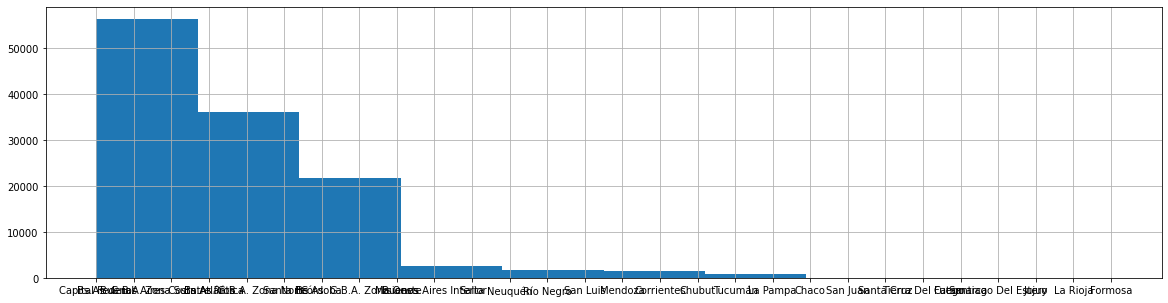

In [ ]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
data_edit['fran_provincia'].hist(ax = ax)
